Name: Mahendran Jinachandran 

Student ID: 24088951


## Why Reinforcement Learning is the ML paradigm of choice for this task?

- I have chosen "NameThisGame" game to work on this task. Reinforcement Learning(RL) is the most suitable for this task because it requires controls and making decisions. Unlike supervised learning methods that rely on large datasets, RL does not require any datasets it rather relies on experiences just like we humans do.

- In the game of "NameThisGame",the goal is to defend the treasure (reward) that you have discovered. You must fight (action) off a shark and an octopus while keeping an eye on your oxygen supply.

- The one thing which separates RL from the other ML techniques is that the agent starts with no experience of the game prior. It learns through trial and error, explores different actions, receives feedback through those actions in from of rewards (dots) or penalties (ghosts) and eventually learns to make better choices to maximize its score. This is one of the techniques, which makes RL a very powerful approach for Atari games and many more, in which the rules are fixed but the strategies will be diffirent which much be learnt. 

Just For Fun: Hopefully, the game learns to make much better decisions than I do in real-life. Let's dive into the game.

## The Environment

In [1]:
# imports
import gym
import cv2 
import os
import time
import random
import numpy as np
import tensorflow as tf
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
# Check for available GPU devices and use them
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error: " + str(e))

In [4]:
os.makedirs("trained_models", exist_ok=True)

a. The Atari game selected:

The atari game selected is "*NameThisGame*". The goal is to defend the treasure (reward) that you have discovered. You must fight (action) off a shark and an octopus while keeping an eye on your oxygen supply. The agent won't have any prior experience in the game and tries to learn the game making it a perfect candidate for Reinforcement Learning.

In [5]:
# Use render_mode="human" for real-time game visualization but it is slower.
# I have used render_mode="rgb_array" since the performance is faster.
# It returns a RGB numpy array.

env = gym.make("ALE/NameThisGame-v5", render_mode="rgb_array") 

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


b. Inputs received from Gym Environment 

The observation shape gives us the dimensions of the input which will be received by the agent in the environment

In [6]:
observation, info = env.reset()

In [7]:
total_lives = info['lives']
print("Total lives: ", total_lives)

Total lives:  3


In [8]:
# It returns a 2D frame with 3 channels. 
# Height = 210, Width = 160, Channels = 3 (RGB)

print("Observation shape:", observation.shape)

Observation shape: (210, 160, 3)


c. Control settings for the JoyStick

The action space gives us the number of possible actions which can be taken by the agent in the environment

In [9]:
num_actions = env.action_space.n
print("Number of possible actions:", num_actions)
print("Available actions are: ")
print(env.unwrapped.get_action_meanings())

Number of possible actions: 6
Available actions are: 
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


/Users/mithesh/Documents/CodeToGreatness/NeuroForge/ReinforcementLearning/myenv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


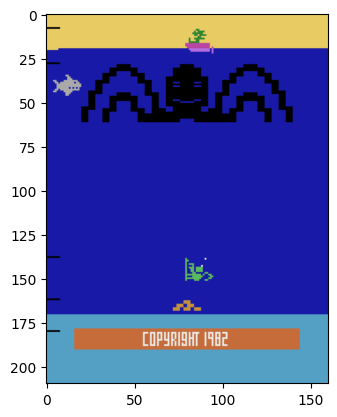

In [10]:
# Below is a frame of the game
plt.imshow(env.render())

##  Vanilla DQN Implementation

a. Capture and Preprocessing of the Data (1 mark)

We are preprocessing because we want to convert the game screen into smaller and simpler image with which the model
can learn from faster and efficiently. We are converting the color (RGB) into grayscale because most Atari games do not require colours. 
I have used opencv2 for preprocessing like resizing and much more. "cv2.INTER_AREA" is used for interpolation. It simply works by averaging the pixels in a region to make one smaller pixel. Normalisation is performed so that the neural network can learn more efficiently.

In [11]:
INPUT_DIM = (84, 84)  # Input dimension for the model

def preprocess_frame_color(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale 
    resized = cv2.resize(gray, INPUT_DIM, interpolation=cv2.INTER_AREA)  # Resize to 84x84 because it is the standard input size for many RL models 
    normalized = resized / 255.0  # The pixel values are in the range of 0-255. Dividing by 255.0 to normalize them to the range of 0-1.
    return normalized

In [ ]:
def initialize_frame_stack(preprocessed_frame, stack_size=4):

    # Initialize a deque of stacked frames with the same frame repeated.
    total_frames = [preprocessed_frame for _ in range(stack_size)]
    return deque(total_frames, maxlen=stack_size)


def stack_frames(stacked_frames, new_frame, is_new_episode, stack_size=4):

    preprocessed_frame = preprocess_frame_color(new_frame)    

    # Initialize a new frame stack if it's a new episode, otherwise append the new frame to the existing stack.
    if is_new_episode:
        stacked_frames = initialize_frame_stack(preprocessed_frame, stack_size)
    else:
        stacked_frames.append(preprocessed_frame)
        
    stacked_state = np.stack(stacked_frames, axis=2)
    return stacked_state, stacked_frames

Stacked state shape: (84, 84, 4)


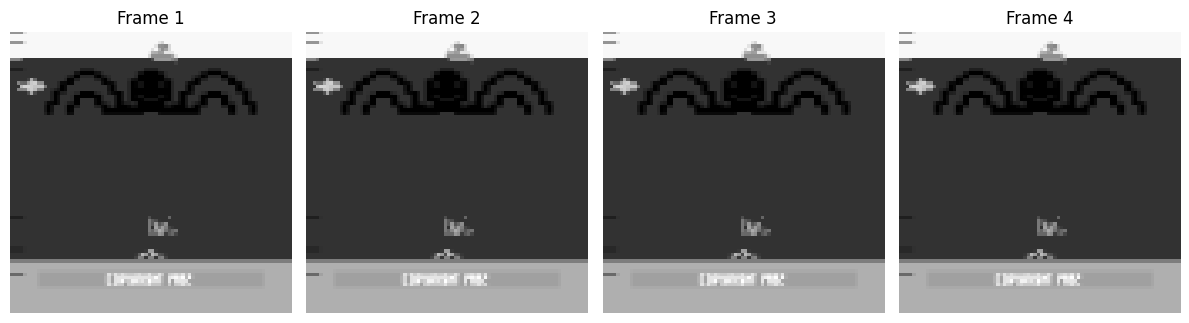

In [ ]:
# Let's test the frame stacking function
state, _ = env.reset()
stacked_frames = deque(maxlen=4)
stacked_state, _ = stack_frames(stacked_frames, state, is_new_episode=True)

# It should be (84, 84, 4) because we are stacking 4 frames and we have resized the frames to 84x84
print("Stacked state shape:", stacked_state.shape) 

# Display all 4 stacked frames
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for idx in range(4):
    axes[idx].imshow(stacked_state[:, :, idx], cmap='gray')
    axes[idx].set_title(f'Frame {idx+1}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

b. The Network Structure (2 marks)

The reference of the DQN architecture is taken from Week 10 of PDF. 

V Mnih et al. Nature 518, 529-533 (2015)

https://www.youtube.com/watch?v=fevMOp5TDQs

https://www.nature.com/articles/nature14236#citeas

In [14]:
def create_vanilla_dqn_model(input_shape, num_actions):
    """
    Create a Convolutional Neural Network for DQN.
    Input shape = (84, 84, 12) for 4 stacked color frames.
    Output = Q-value for each action.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (8, 8), strides=4, activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(64, (4, 4), strides=2, activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Dropout to avoid overfitting
        
        layers.Dense(num_actions) 
    ])
    
    return model

c. Q-Learning Update (2 marks)

In [15]:
def convert_batch_to_tensors(batch, dtypes):
    return tuple(tf.convert_to_tensor(item, dtype=dtype) for item, dtype in zip(batch, dtypes))


In [16]:
def update_model(main_model, target_model, optimizer, batch, gamma=0.99):

    dtypes = (tf.float32, tf.int32, tf.float32, tf.float32, tf.float32)
    states, actions, rewards, next_states, dones = convert_batch_to_tensors(batch, dtypes)

    with tf.GradientTape() as tape:
        # Get Q(s, a)
        q_values = main_model(states)
        q_action = tf.gather(q_values, actions, axis=1, batch_dims=1)


        # Predict Q(s', a') using target model
        next_q_values = target_model(next_states)
        max_next_q = tf.reduce_max(next_q_values, axis=1)
        target_q = rewards + gamma * max_next_q * (1.0 - dones)

        # Loss between predicted and target Q-values
        loss = tf.keras.losses.MSE(target_q, q_action)

    # Apply gradients
    grads = tape.gradient(loss, main_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_model.trainable_variables))
    
    return loss.numpy()


The below code "ReplayBuffer" is used to store the agent's experiences as it interacts with the environment. 

In [17]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [27]:
# Hyperparameters
GAMMA = 0.99 # Discount factor
EPSILON = 1.0   # Exploration rate
EPSILON_MIN = 0.1 # Minimum exploration rate
EPSILON_DECAY = 0.995 # Decay rate
LEARNING_RATE = 0.00025 # Learning rate
REPLAY_BUFFER_SIZE = 100000
BATCH_SIZE = 32 # Batch size for training
TARGET_UPDATE_FREQ = 1000 # Frequency to update target model
STACK_SIZE =  4 # Number of frames to stack
TOTAL_EPISODES = 20 # Total episodes to train
MAX_STEPS = 5000 # Max steps per episode
input_shape = (84, 84, STACK_SIZE) # 4 stacked frames

In [28]:
# Models and optimizer
dqn_main_model = create_vanilla_dqn_model(input_shape, num_actions)
dqn_target_model = tf.keras.models.clone_model(dqn_main_model)

dqn_target_model.set_weights(dqn_main_model.get_weights())
dqn_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

# Replay buffer
dqn_replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)

# Frame stack
dqn_stacked_frames = deque(maxlen=STACK_SIZE)

In [29]:
def choose_action(stacked_state, main_model):
    # Epsilon-greedy action
    if np.random.rand() < EPSILON:
        action = env.action_space.sample()
    else:
        q_values = main_model(np.expand_dims(stacked_state, axis=0), training=False)
        action = np.argmax(q_values.numpy())
    return action

In [30]:
def save_model(model, model_name):
    path = os.path.join("trained_models", f"dqn_{model_name}.h5")
    model.save(path)

In [ ]:
def run_episode_step(env, stacked_state, stacked_frames, replay_buffer, main_model, target_model, optimizer, step_count):
    total_reward = 0
    losses = []
    done = False

    for step in tqdm(range(MAX_STEPS), desc="Episode Steps", leave=False):
        step_count += 1

        action = choose_action(stacked_state, main_model)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        next_stacked_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        # Store experience
        replay_buffer.add((stacked_state, action, reward, next_stacked_state, float(done)))
        stacked_state = next_stacked_state
        total_reward += reward

        # Train enough samples
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = update_model(main_model, target_model, optimizer, batch, gamma=GAMMA)
            losses.append(loss)

        # Update target network
        if step_count % TARGET_UPDATE_FREQ == 0:
            target_model.set_weights(main_model.get_weights())
            print(f"Step {step_count} - Target network updated.")

        if done:
            break

    return total_reward, stacked_state, stacked_frames, losses, step_count

In [ ]:
def train_dqn(dqn_type, main_model, target_model, optimizer, replay_buffer, stacked_frames):
    training_start_time = time.time()
    step_count = 0
    episode_rewards = []
    epsilons = []
    losses = []

    print(f"Training of {dqn_type} DQN started...")
    for episode in tqdm(range(TOTAL_EPISODES), desc="Training Episodes"):
        start_time = time.time()

        state, _ = env.reset()
        stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)

        total_reward, stacked_state, stacked_frames, step_losses, step_count = run_episode_step(
            env, stacked_state, stacked_frames, replay_buffer, main_model, target_model, optimizer, step_count
        )
       
        if episode % 50 == 0:
            save_model(main_model, dqn_type)
            print(f"Model saved at episode {episode}.")

        losses.append(step_losses)
        # Decay epsilon
        global EPSILON
        EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
        
        elapsed = time.time() - start_time
        episode_rewards.append(total_reward)
        epsilons.append(EPSILON)
        tqdm.write(f"Episode {episode + 1}/{TOTAL_EPISODES} - Reward: {total_reward} - Epsilon: {EPSILON:.4f} - Time: {elapsed:.2f}s")

    total_training_time = time.time() - training_start_time
    return episode_rewards, epsilons, losses, total_training_time

In [32]:
dqn_episode_rewards, dqn_epsilons, dqn_losses, dqn_total_training_time = train_dqn("Q-Learning", dqn_main_model, dqn_target_model, dqn_optimizer, dqn_replay_buffer, dqn_stacked_frames)

Training of Q-Learning DQN started...


Training Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 1000 - Target network updated.
Step 2000 - Target network updated.
Step 3000 - Target network updated.


/Users/mithesh/Documents/CodeToGreatness/NeuroForge/ReinforcementLearning/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at episode 0.
Episode 1/20 - Reward: 3160.0 - Epsilon: 0.9950 - Time: 122.86s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 4000 - Target network updated.
Step 5000 - Target network updated.
Episode 2/20 - Reward: 1490.0 - Epsilon: 0.9900 - Time: 77.23s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 6000 - Target network updated.
Step 7000 - Target network updated.
Episode 3/20 - Reward: 2400.0 - Epsilon: 0.9851 - Time: 100.38s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 8000 - Target network updated.
Step 9000 - Target network updated.
Episode 4/20 - Reward: 1080.0 - Epsilon: 0.9801 - Time: 64.08s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 10000 - Target network updated.
Step 11000 - Target network updated.
Step 12000 - Target network updated.
Episode 5/20 - Reward: 3560.0 - Epsilon: 0.9752 - Time: 163.39s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 13000 - Target network updated.
Step 14000 - Target network updated.
Step 15000 - Target network updated.
Episode 6/20 - Reward: 1750.0 - Epsilon: 0.9704 - Time: 125.58s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 16000 - Target network updated.
Step 17000 - Target network updated.
Step 18000 - Target network updated.
Episode 7/20 - Reward: 3170.0 - Epsilon: 0.9655 - Time: 204.12s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 19000 - Target network updated.
Step 20000 - Target network updated.
Episode 8/20 - Reward: 1860.0 - Epsilon: 0.9607 - Time: 158.92s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 21000 - Target network updated.
Step 22000 - Target network updated.
Episode 9/20 - Reward: 2070.0 - Epsilon: 0.9559 - Time: 227.64s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 23000 - Target network updated.
Step 24000 - Target network updated.
Step 25000 - Target network updated.
Step 26000 - Target network updated.
Step 27000 - Target network updated.
Episode 10/20 - Reward: 4010.0 - Epsilon: 0.9511 - Time: 561.12s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 28000 - Target network updated.
Episode 11/20 - Reward: 720.0 - Epsilon: 0.9464 - Time: 152.98s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 29000 - Target network updated.
Step 30000 - Target network updated.
Episode 12/20 - Reward: 1940.0 - Epsilon: 0.9416 - Time: 299.84s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 31000 - Target network updated.
Step 32000 - Target network updated.
Step 33000 - Target network updated.
Episode 13/20 - Reward: 2710.0 - Epsilon: 0.9369 - Time: 252.81s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 34000 - Target network updated.
Step 35000 - Target network updated.
Step 36000 - Target network updated.
Episode 14/20 - Reward: 2620.0 - Epsilon: 0.9322 - Time: 354.88s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 37000 - Target network updated.
Step 38000 - Target network updated.
Episode 15/20 - Reward: 2520.0 - Epsilon: 0.9276 - Time: 359.57s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 39000 - Target network updated.
Step 40000 - Target network updated.
Step 41000 - Target network updated.
Step 42000 - Target network updated.
Episode 16/20 - Reward: 3530.0 - Epsilon: 0.9229 - Time: 422.31s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 43000 - Target network updated.
Step 44000 - Target network updated.
Episode 17/20 - Reward: 1860.0 - Epsilon: 0.9183 - Time: 209.87s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 45000 - Target network updated.
Step 46000 - Target network updated.
Step 47000 - Target network updated.
Episode 18/20 - Reward: 2280.0 - Epsilon: 0.9137 - Time: 307.91s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 48000 - Target network updated.
Episode 19/20 - Reward: 1020.0 - Epsilon: 0.9092 - Time: 161.43s


Episode Steps:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 49000 - Target network updated.
Step 50000 - Target network updated.
Step 51000 - Target network updated.
Episode 20/20 - Reward: 2860.0 - Epsilon: 0.9046 - Time: 357.28s


## Results and Evaluation
a. Plots

In [33]:
# A generic method to display training metrics
# such as rewards, epsilon, and loss
def plot_training_metric(metric_values, title="Training Metric", ylabel="Value", xlabel="Episode", label=None, color='blue'):
    plt.figure(figsize=(10, 4))
    plt.plot(metric_values, label=label if label else ylabel, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

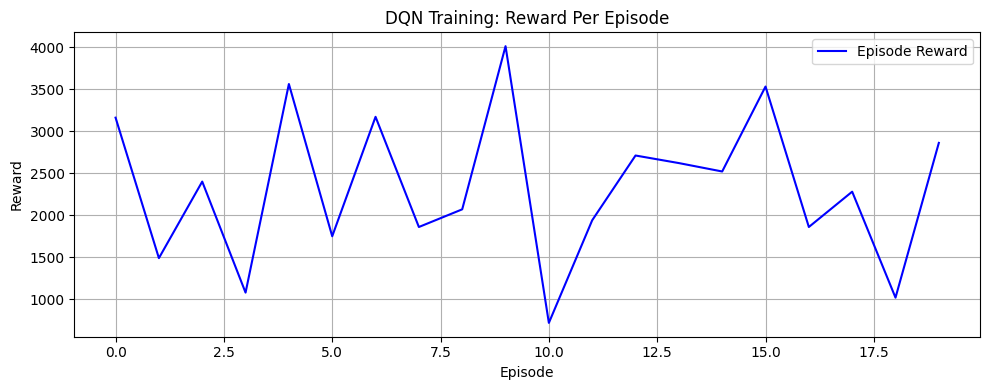

In [34]:
plot_training_metric(dqn_episode_rewards, title="DQN Training: Reward Per Episode", ylabel="Reward", label="Episode Reward", color="blue")

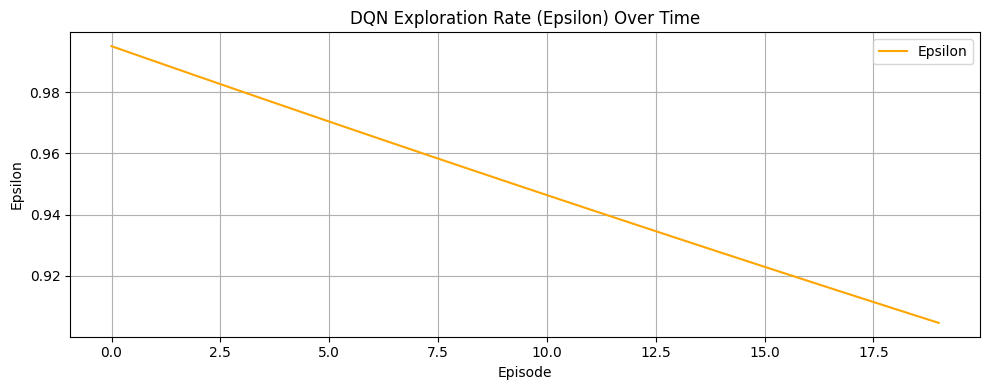

In [35]:
plot_training_metric(dqn_epsilons, title="DQN Exploration Rate (Epsilon) Over Time", ylabel="Epsilon", label="Epsilon", color="orange")

In [38]:
flat_losses = [loss for episode_losses in dqn_losses for loss in episode_losses]

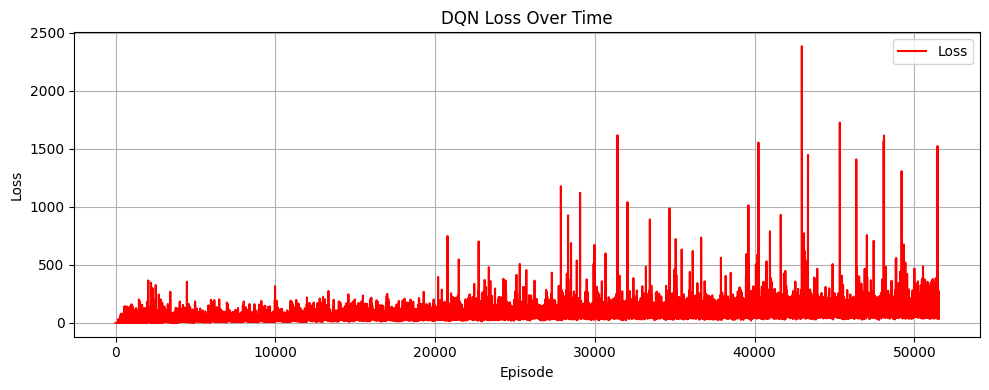

In [39]:
plot_training_metric(flat_losses, title="DQN Loss Over Time", ylabel="Loss", label="Loss", color="red")

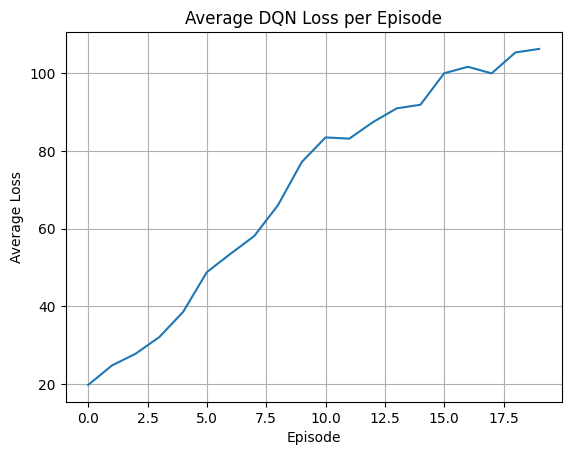

In [41]:
avg_losses = [sum(l) / len(l) if len(l) > 0 else 0 for l in dqn_losses]

plt.plot(avg_losses)
plt.xlabel("Episode")
plt.ylabel("Average Loss")
plt.title("Average DQN Loss per Episode")
plt.grid(True)
plt.show()


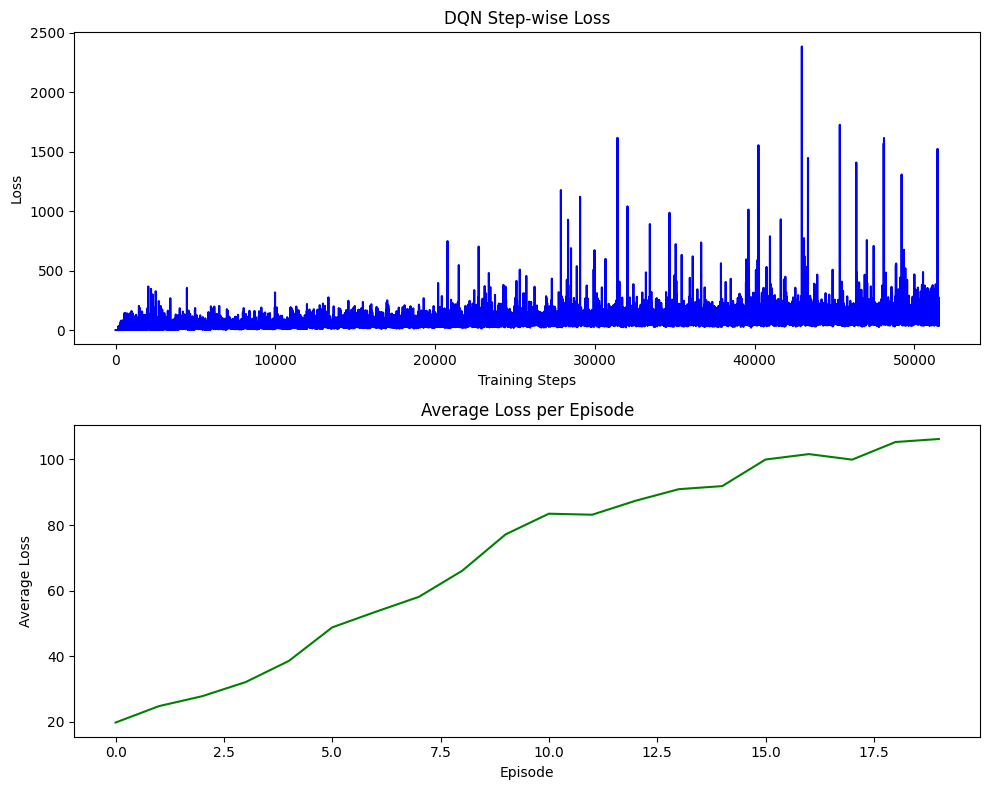

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Step-wise loss
axs[0].plot(flat_losses, color='blue')
axs[0].set_title("DQN Step-wise Loss")
axs[0].set_xlabel("Training Steps")
axs[0].set_ylabel("Loss")

# Avg episode loss
axs[1].plot(avg_losses, color='green')
axs[1].set_title("Average Loss per Episode")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Average Loss")

plt.tight_layout()
plt.show()


b. How does one evaluate the performance of the RL agent?

c. Is the agent learning?

## DOUBLE DQN implementation